# Toy (counter-)example for anomaly decomposition

This is a carefully crafted example to demonstrate two possibly counter-intuitive results in anomaly decomposition study:
- ROC AUC < 0.5
- AUC for 'all good' is lower than for some other 'subsystems'.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Introducing 3 real subsystems and generating labels for them (1 - good, 0 - anomaly).

In [2]:
### Good 80% of the time
rd1 = np.random.binomial(1, p=0.8, size=1000)

### Good 80% of the time
rd2 = np.random.binomial(1, p=0.8, size=1000)

### This detector is anti-correlated with the second detector 
rd3 = np.where(rd2 == 1, np.random.binomial(1, p = 0.7, size=1000), 1)

### 1&2 Good
rd12 = rd1 * rd2

### 1&3 Good
rd13 = rd1 * rd3

### 2&3 good
rd23 = rd2 * rd3

### All good
rd123 = rd12 * rd3

In [3]:
np.mean(rd123)

0.439

$\mathrm{score}_i$ variables represent classifier's prediction for each of the subdetectors.
By construction $\mathrm{score}_i$ has high discriminative power against $i$-th detector.

In [4]:
### just some noise introduced into the true labels.
score1 = np.random.normal(scale=0.2, size=1000) + rd1
score2 = np.random.normal(scale=0.3, size=1000) + rd2
score3 = np.random.normal(scale=0.4, size=1000) + rd3

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
roc_aucs = np.ndarray(shape=(3, 7))

for i, score in enumerate([score1, score2, score3]):
    for j, rd in enumerate([rd1, rd2, rd3, rd12, rd13, rd23, rd123]):
        roc_aucs[i, j] = roc_auc_score(rd, score)

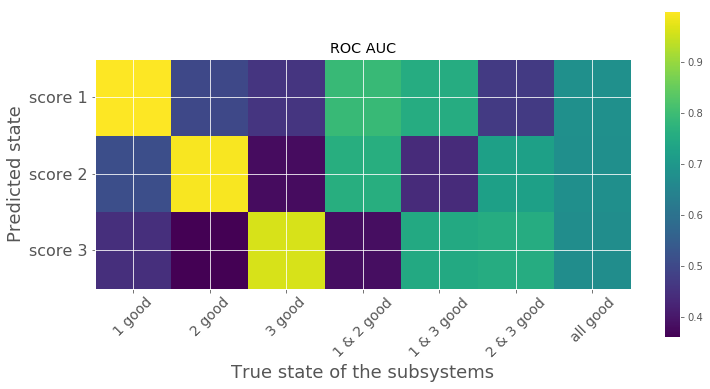

In [14]:
plt.figure(figsize=(12, 6))
plt.imshow(roc_aucs)
plt.yticks(np.arange(3), ['score 1', 'score 2', 'score 3'], fontsize=16)
plt.xticks(
    np.arange(7),
    ['1 good', '2 good', '3 good', '1 & 2 good', '1 & 3 good', '2 & 3 good', 'all good'],
    fontsize=14, rotation= 45
)
plt.title('ROC AUC')
plt.xlabel('True state of the subsystems', fontsize=18)
plt.ylabel('Predicted state', fontsize=18)
plt.colorbar()

Observations:

- $\mathrm{score}_i$, indeed, have high ROC AUC against corresponding true states;
- $\mathrm{score}_2$ has ROC AUC < 0.5 against subsystem 3;
- the same for $\mathrm{score}_3$ vs subsystem 2;
- 'all good' has relatevely low score in spite of each score having high ROC AUC against corersponding subsystem.

In [10]:
metrics = np.ndarray(shape=(3, 7, 4))

for i, score in enumerate([score1, score2, score3]):
    pred = score > 0.5

    for j, rd in enumerate([rd1, rd2, rd3, rd12, rd13, rd23, rd123]):
        tp = float(np.sum((pred == 1) & (rd == 1)))
        fp = float(np.sum((pred == 1) & (rd == 0)))
        tn = float(np.sum((pred == 0) & (rd == 0)))
        fn = float(np.sum((pred == 0) & (rd == 1)))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        spc = tn / (tn + fp)
        p = tn / (tn + fn)
        roc = roc_auc_score(rd, score)
        
        metrics[i, j] = (precision, recall, spc, p)

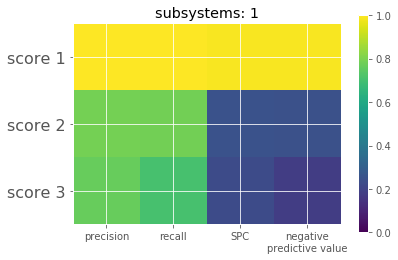

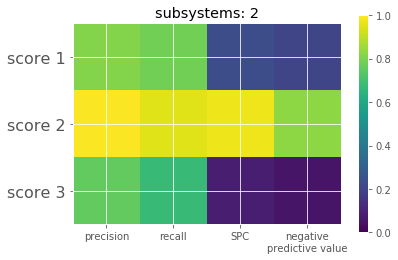

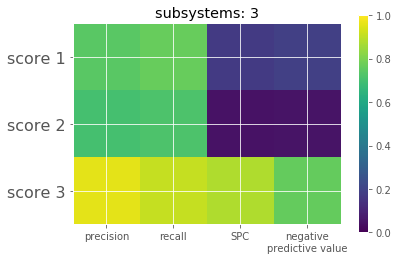

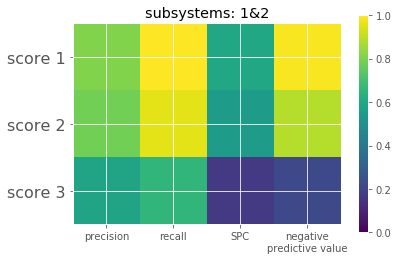

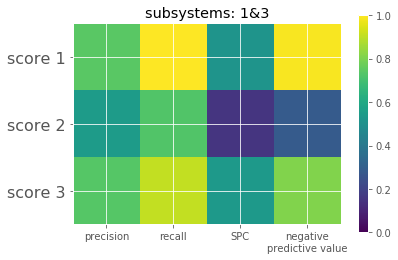

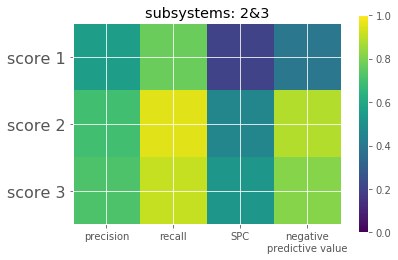

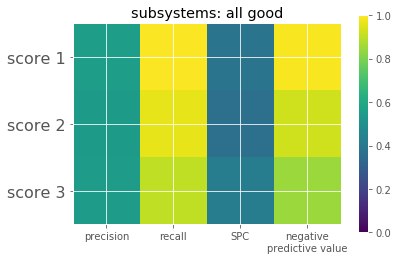

In [12]:
for j, rd in enumerate(['1', '2', '3', '1&2', '1&3', '2&3', 'all good']):
    plt.figure()
    plt.imshow(metrics[:, j, :], vmin=0, vmax=1)
    plt.title('subsystems: %s' % rd)
    plt.xticks(np.arange(4), ['precision', 'recall', 'SPC', 'negative\npredictive value'])
    plt.yticks(np.arange(3), ['score 1', 'score 2', 'score 3'], fontsize=16)
    plt.colorbar()
    plt.show()